# SVM Classifier

## Data Preprocessing

### Train-Test Split the Songs
It is important to create a train-test split of the songs *before* the splitting each song into three-second segments as to avoid mixing segments of the test songs into the actual training set.

In [31]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

df_songs = pd.read_csv('../features_30_sec.csv')
df_segments = pd.read_csv('../features_3_sec.csv')

X = df_songs
y = df_songs['label']

X_train_songs, X_test_songs, y_train_songs, y_test_songs = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_filenames = X_train_songs['filename']
test_filenames = X_test_songs['filename']


Given the song names in the train set and test set, it is necessary to get all 3-second segments corresponding to each song. In the CSV files, the full songs are in the format **[Genre].[Song Number].wav** whereas the segmented songs are in the format **[Genre].[Song Number].[Segment].wav**, so the segments can be extracted using some RegEx to get a mask.

In [32]:
train_mask = (df_segments['filename'].str.extract(r'(.*\.\d+)\.\d+\.wav')[0]+ '.wav').isin(train_filenames)
test_mask = (df_segments['filename'].str.extract(r'(.*\.\d+)\.\d+\.wav')[0]+ '.wav').isin(test_filenames)
df_train_segments = df_segments[train_mask].reset_index(drop=True)
df_test_segments = df_segments[test_mask].reset_index(drop=True)

### Drop Unnecessary Columns
The name of the file is obviously cheating, and all songs have roughly the same length (give or take a few frames), so the length is also an unnecessary column. The label is what is being predicted, so it is also dropped.

In [33]:
X_train_segments = df_train_segments.drop(columns=['filename', 'length', 'label'])
y_train_segments = df_train_segments['label']

## Model Selection

### Model Parameter Selection

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np

X_train, X_val, y_train, y_val = train_test_split(X_train_segments, y_train_segments, test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train_segments, y_train_segments, test_size=0.2, random_state=42)

param_grid = {
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto']
}

svc = SVC()
pipeline = make_pipeline(StandardScaler(), svc)

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best cross-validation accuracy: {grid_search.best_score_}')

best_model = grid_search.best_estimator_
val_score = best_model.score(X_val, y_val)
print(f'Validation accuracy with best model: {val_score}')


Best parameters found: {'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best cross-validation accuracy: 0.9059768916688384
Validation accuracy with best model: 0.9292866082603254


### Feature Selection

Since there are a lot of features to select from, K-fold cross validation was not performed out of interest of time. Rather, backwards feature selection was utilized with just the validation set.

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_val, y_train, y_val = train_test_split(X_train_segments, y_train_segments, test_size=0.2)

svc = SVC(C=100, gamma='scale', kernel='rbf')
base_model = make_pipeline(StandardScaler(), svc)

remaining_features = list(X_train.columns)
best_score = 0
improvement = True

while improvement and len(remaining_features) > 0:
    improvement = False
    scores = []
    
    for feature in remaining_features:
        selected_features = [f for f in remaining_features if f != feature]
        X_train_selected = X_train[selected_features]
        X_val_selected = X_val[selected_features]
        
        base_model.fit(X_train_selected, y_train)
        val_score = base_model.score(X_val_selected, y_val)
        scores.append((val_score, feature))
    
    new_best_score, best_feature_to_remove = max(scores)
    
    if new_best_score > best_score:
        best_score = new_best_score
        remaining_features.remove(best_feature_to_remove)
        improvement = True
        print(f'Removed feature "{best_feature_to_remove}", new validation accuracy: {best_score}')

X_train_selected = X_train[remaining_features]
X_val_selected = X_val[remaining_features]

clf = base_model.fit(X_train_selected, y_train)

final_val_score = clf.score(X_val_selected, y_val)
print(f'Final validation accuracy: {final_val_score}')
print(f'Selected features: {remaining_features}')

Removed feature "tempo", new validation accuracy: 0.928035043804756
Removed feature "mfcc12_var", new validation accuracy: 0.9330413016270338
Final validation accuracy: 0.9330413016270338
Selected features: ['chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc13_mean', 'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean', 'm

In [34]:
clf_final = base_model.fit(X_train_segments[remaining_features], y_train_segments)

## Evaluation

Here, the evaluation is done as a *majority vote* of the genres from each song segment. 

In [35]:
def majority_vote(predictions):
    return predictions.mode().iloc[0]

From the confusion matrix, it appears as if the SVM model is best at identifying classical music and worst at identifying rock and disco.

Accuracy Score:
0.795


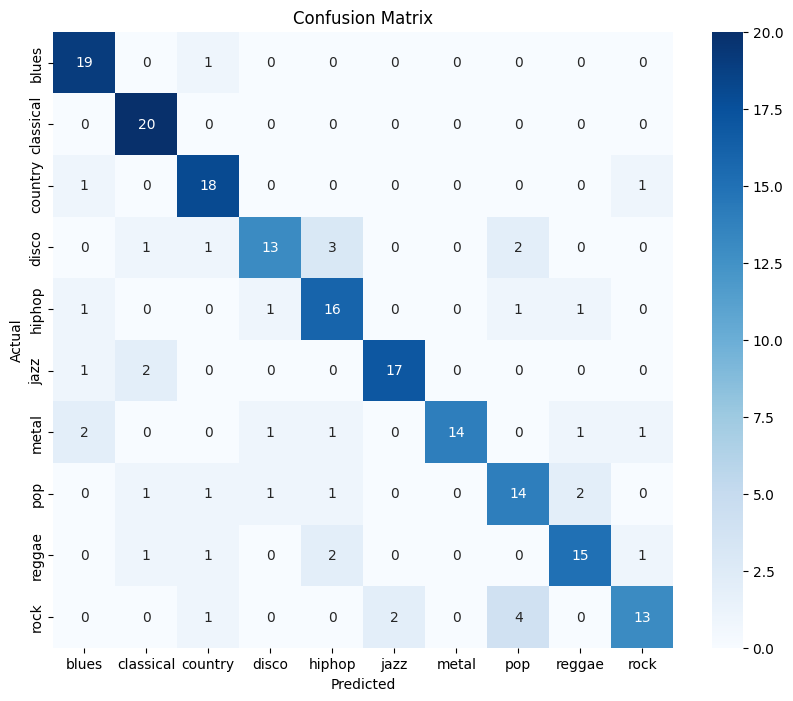

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from matplotlib import pyplot as plt

X_test_segments = df_test_segments[remaining_features]
y_test_segments = df_test_segments['label']

df_test_segments['predicted_label'] = clf_final.predict(X_test_segments)

df_test_segments['song'] = df_test_segments['filename'].str.extract(r'(.*\.\d{5})')[0] + '.wav'
song_predictions = df_test_segments.groupby('song')['predicted_label'].apply(majority_vote)

song_true_labels = X_test_songs.set_index('filename').loc[song_predictions.index, 'label']

print("Accuracy Score:")
print(accuracy_score(song_true_labels, song_predictions))

cm = confusion_matrix(song_true_labels, song_predictions, labels=song_true_labels.unique())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=song_true_labels.unique(), yticklabels=song_true_labels.unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
